In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('crypto-markets.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
df.head()

slug symbol     name  ranknow    open    high     low   close  \
date                                                                           
2013-04-28  bitcoin    BTC  Bitcoin        1  135.30  135.98  132.10  134.21   
2013-04-29  bitcoin    BTC  Bitcoin        1  134.44  147.49  134.00  144.54   
2013-04-30  bitcoin    BTC  Bitcoin        1  144.00  146.93  134.05  139.00   
2013-05-01  bitcoin    BTC  Bitcoin        1  139.00  139.89  107.72  116.99   
2013-05-02  bitcoin    BTC  Bitcoin        1  116.38  125.60   92.28  105.21   

            volume      market  close_ratio  spread  
date                                                 
2013-04-28       0  1500520000       0.5438    3.88  
2013-04-29       0  1491160000       0.7813   13.49  
2013-04-30       0  1597780000       0.3843   12.88  
2013-05-01       0  1542820000       0.2882   32.17  
2013-05-02       0  1292190000       0.3881   33.32

In [3]:
df.tail()

slug symbol          name  ranknow   open   high    low  \
date                                                                          
2018-02-01  bitcoin-atom    BCA  Bitcoin Atom     1515  45.95  55.17  41.70   
2018-02-02  bitcoin-atom    BCA  Bitcoin Atom     1515  42.90  42.90  29.18   
2018-02-03  bitcoin-atom    BCA  Bitcoin Atom     1515  35.99  36.71  30.10   
2018-02-04  bitcoin-atom    BCA  Bitcoin Atom     1515  30.75  34.90  23.93   
2018-02-05  bitcoin-atom    BCA  Bitcoin Atom     1515  25.52  27.42  19.25   

            close  volume  market  close_ratio  spread  
date                                                    
2018-02-01  42.95   38029       0       0.0928   13.47  
2018-02-02  35.91   48024       0       0.4905   13.72  
2018-02-03  30.74   27136       0       0.0968    6.61  
2018-02-04  23.93   26370       0       0.0000   10.97  
2018-02-05  19.68   17804       0       0.0526    8.17

In [4]:
# Extract the bitcoin data only
btc=df[df['symbol']=='BTC']
# Drop some columns
btc.drop(['slug', 'volume','symbol','name','ranknow','market', 'close_ratio', 'spread'],axis=1,inplace=True) 

In [5]:
btc.head()

open    high     low   close
date                                      
2013-04-28  135.30  135.98  132.10  134.21
2013-04-29  134.44  147.49  134.00  144.54
2013-04-30  144.00  146.93  134.05  139.00
2013-05-01  139.00  139.89  107.72  116.99
2013-05-02  116.38  125.60   92.28  105.21

In [6]:
# Lets take just the last year 
#btc = btc.loc['2017']
#btc.shape

# Monthly Forecasting <a name="monthlyForecasting"></a>

In [7]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

## Stationarity check and Seasonal decomposition <a name="StationarityCheck"></a>

If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

Dickey–Fuller test: p=0.998803


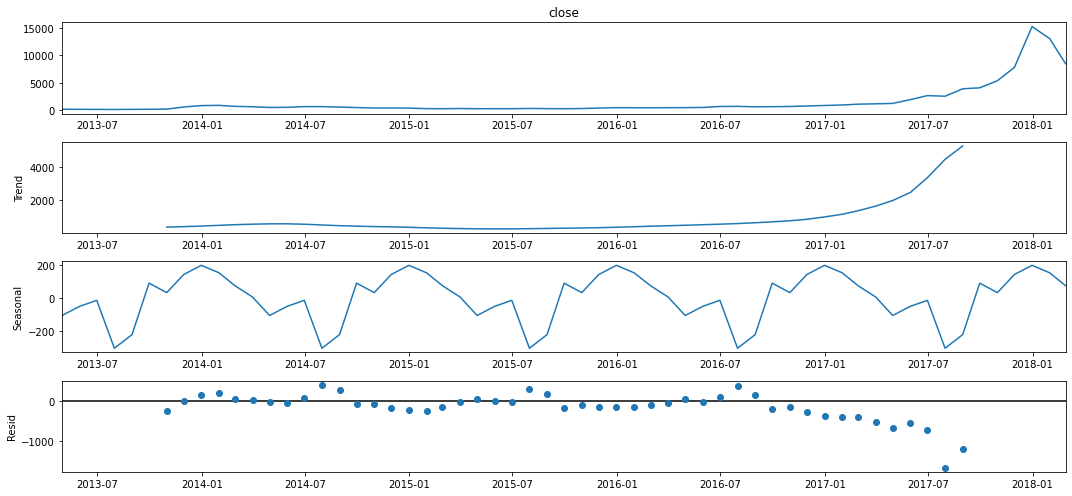

In [8]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close)[1])
plt.show()

The p-value indicates that series is not stationary with 99.88% confidence.

## Box-Cox Transformation <a name="Transformation"></a>

Lets use the Box-Cox transformation to suppress some of the variance.

In [9]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.494475


The p-value indicates that series is still not stationary.

## Differencing <a name="Differencing"></a>


### Seasonal differentiation  <a name="SeasonalDifferentiation"></a>

One method of differencing data is seasonal differencing, which involves computing the difference between an observation and the corresponding observation in the previous year.

In [10]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.661446


The p-value indicates that series is still not stationary.

In [11]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.018033


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05.

### Regular differentiation  <a name="RegularDifferentiation"></a>

Sometimes it may be necessary to difference the data a second time to obtain a stationary time series, which is referred to as second order differencing.

Dickey–Fuller test: p=0.002424


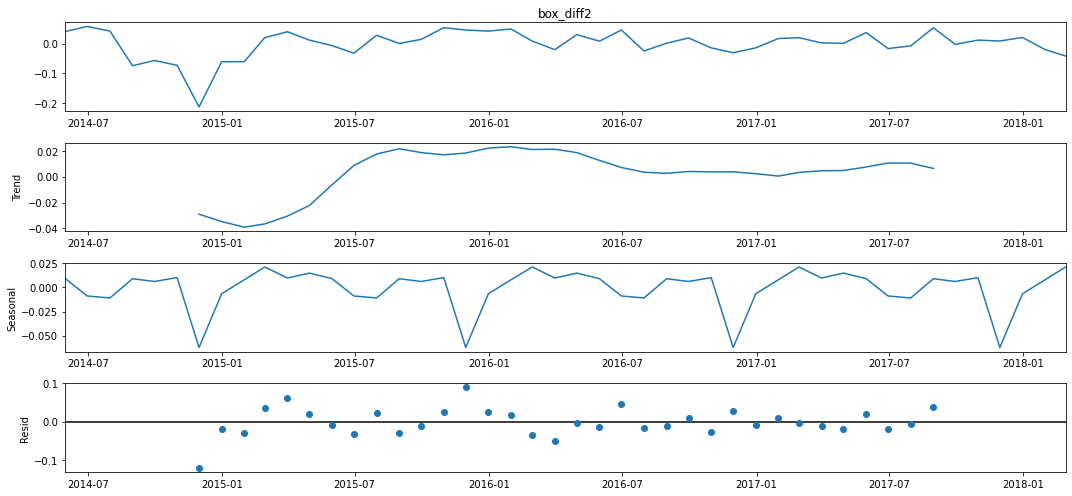

In [12]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05. 

### Autocorrelation  <a name="Autocorrelation"></a>


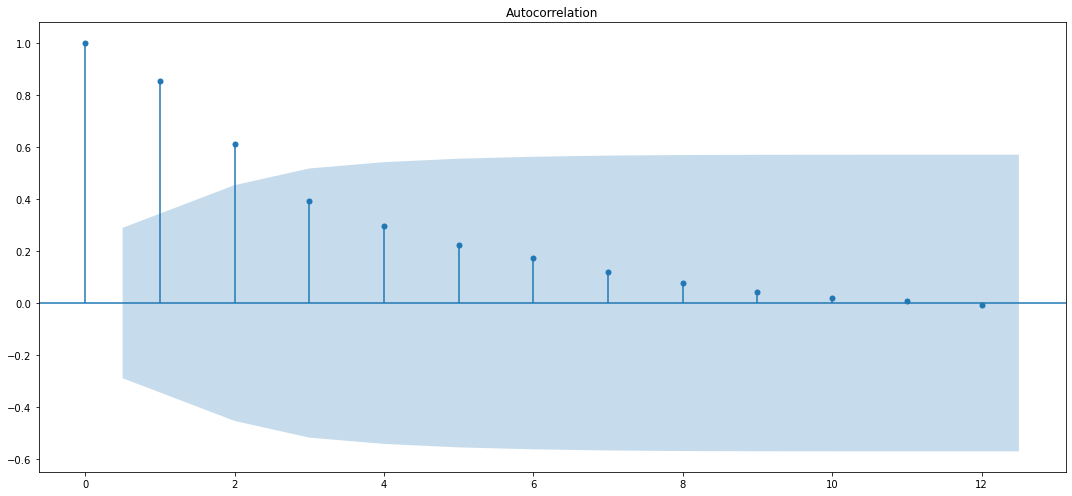

In [13]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

There is a positive correlation with the first 10 lags that is perhaps significant for the first 2-3 lags.

A good starting point for the AR parameter of the model may be 3.

Lets try out autocorrelation on the differences...

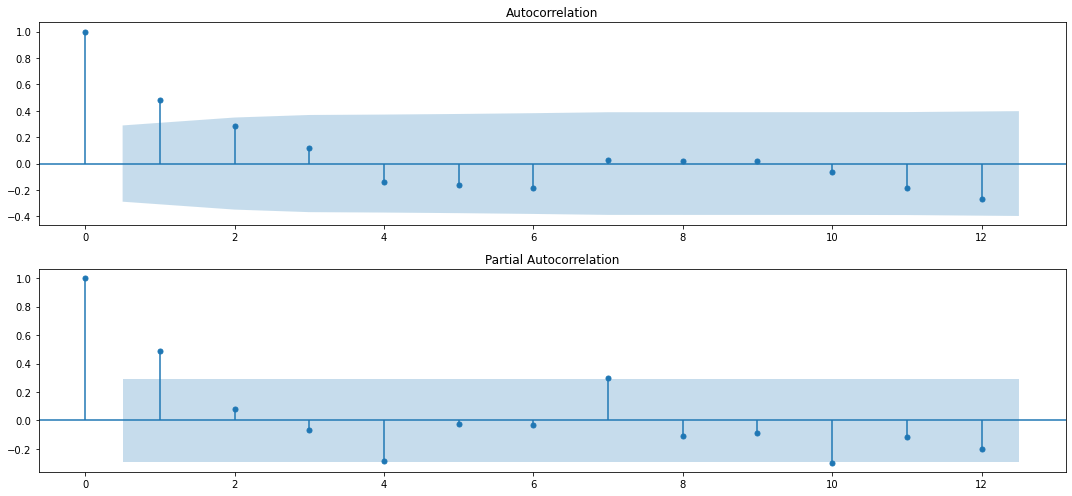

In [14]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

There are not many spikes in the plots outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models. 

There may be a seasonal component available in the residuals at the lags of quarters (3 months) represented by spikes at these intervals. But probably not significant.

## ARIMA Model  <a name="ARIMAModel"/>
AutoRegressive Integrated Moving Average


#### Parameter Selection

In [15]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Note that some parameter combinations may lead to numerical misspecifications and we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we catch these exceptions and just print out the parameter combinations that cause these issues.

In [16]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -220.113585
1     (0, 1) -219.765328
4     (1, 1) -218.164000
6     (2, 0) -218.152064
2     (0, 2) -217.954255


Note the AICs are negative but this is not a problem.

Usually, AIC is positive; however, it can be shifted by any additive constant, and some shifts can result in negative values of AIC. It is not the absolute size of the AIC value, it is the relative values over the set of models considered, and particularly the differences between AIC values, that are important.



In [17]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   59
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 112.057
Date:                Wed, 11 May 2022   AIC                           -220.114
Time:                        13:24:56   BIC                           -215.993
Sample:                    04-30-2013   HQIC                          -218.508
                         - 02-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3743      0.152      2.470      0.014       0.077       0.671
sigma2         0.0012      0.000     11.215      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

### Analysis of Results  <a name="AnalysisARIMA"></a>

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.


When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [18]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.006637


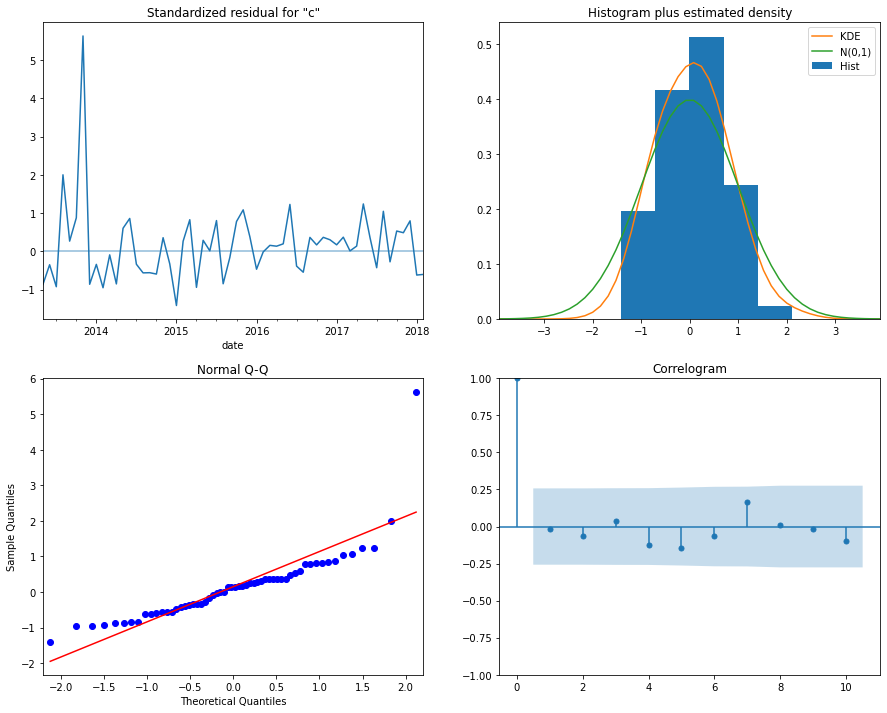

In [19]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

    In the histogram (top right), the KDE line should follow the N(0,1) line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

    In the Q-Q-plot the ordered distribution of residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is an indication whether the residuals are normally distributed.

    The standardized residual plot doesn't display any obvious seasonality. 
    This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged versions of itself.

Conclusion: We may consider trying to standardise the distribution further. But lets go ahead and do a prediction anyway...

## Prediction  <a name="PredictionARIMA"></a>

In [20]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

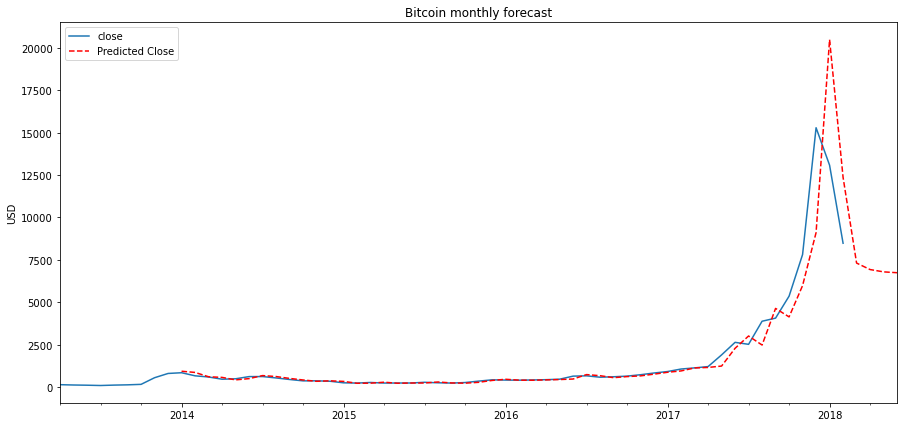

In [21]:
# Prediction
btc_month_pred = btc_month[['close']]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
#             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
#             datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)


plt.figure(figsize=(15,7))
btc_month_pred.close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()

## SARIMA  Model  <a name="SARIMAXModel"/>
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model


#### Parameter Selection


In [22]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [23]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
21  (1, 0, 1, 1) -193.013189
49  (2, 2, 0, 1) -192.913073
19  (1, 0, 0, 1) -192.521383
7   (0, 1, 0, 1) -192.253144
9   (0, 1, 1, 1) -192.175004
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   59
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 100.507
Date:                             Wed, 11 May 2022   AIC                           -193.013
Time:                                     13:25:17   BIC                           -185.057
Sample:                                 04-30-2013   HQIC                          -189.945
                                      - 02-28-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

### Analysis of Results  <a name="AnalysisSARIMAX"></a>

In [24]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.085339


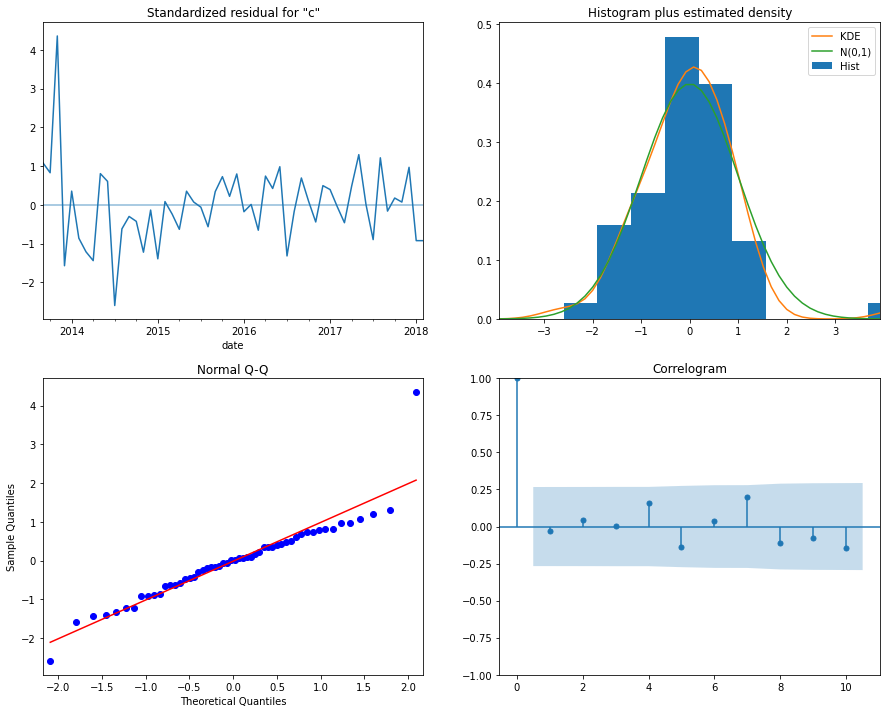

In [25]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.085339


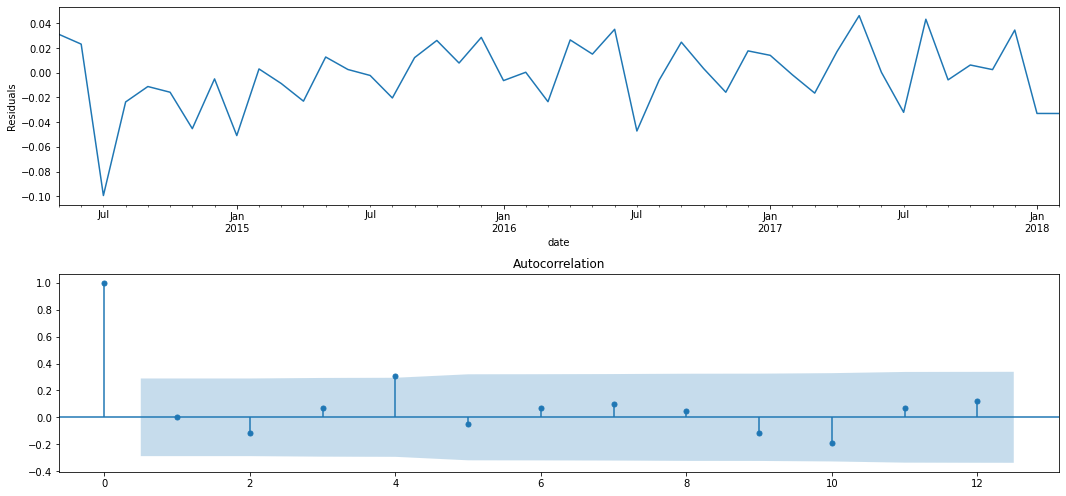

In [26]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

## Prediction  <a name="PredictionSARIMAX"></a>

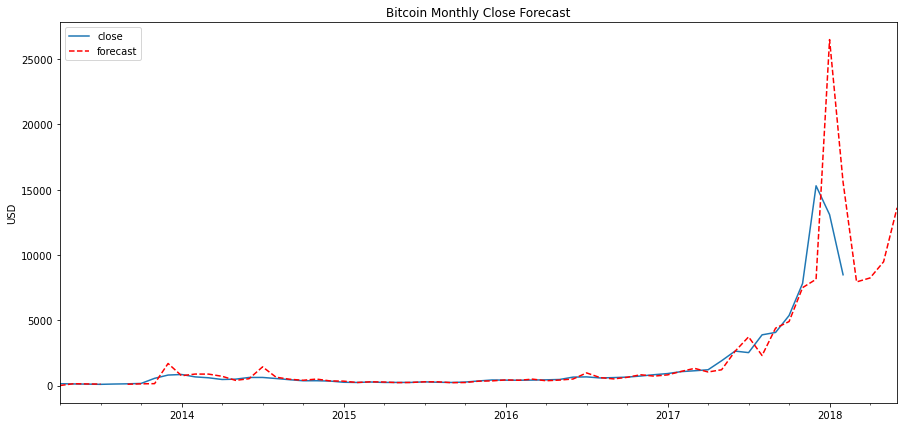

In [27]:
# Prediction
btc_month2 = btc_month[['close']]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

## Validation <a name="validationSARIMAX"></a>

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So lets calcualte RMSE for the one-step ahead predictions starting from 2015, through to the end of 2017.

In [28]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2015-01-01':'2017-01-01'].close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 85.18


A better representation of longer-term predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from mid 2017 onwards.

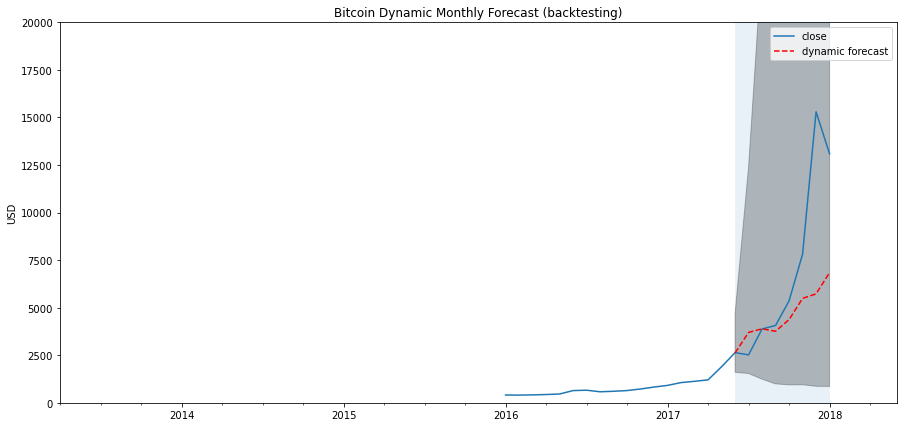

In [29]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-06-30')
t2 = pd.to_datetime('2018-01-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,20000))

btc_month2.close['2016':'2018-01'].plot(label='close')
btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

This is pretty bad but not surprising given how the prices started going insane around late 2017. Lets see how well the model does in a different time period when things were a little more normal.

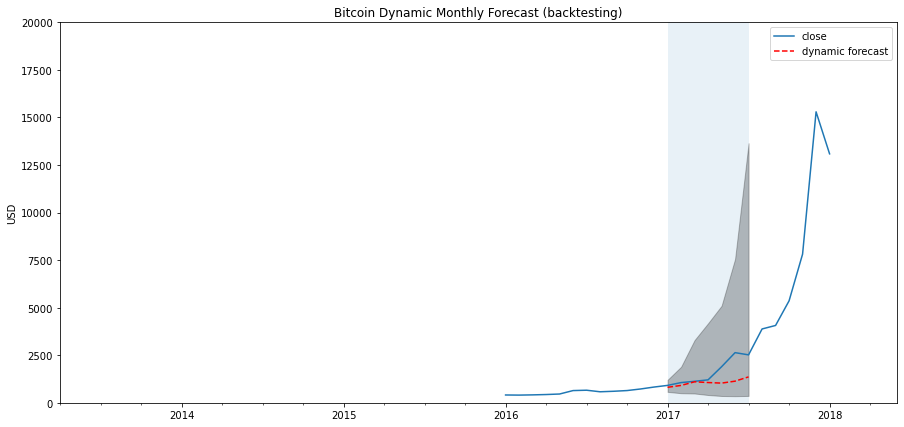

In [30]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-01-31')
t2 = pd.to_datetime('2017-07-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,20000))

btc_month2.close['2016':'2018-01'].plot(label='close')
btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()